# Neural Network Project (1)
# Weather Prediction and forcasting.

This notebook is focused on predicting weather conditions using a dataset containing historical weather data. The process involves several steps, including data loading, preprocessing, exploratory data analysis, and building a LSTM Model and a GRU Model and comparing the Performance of both models on the dataset.

# Importing Necessary Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Reading the data, preprocessing and feature engineering to prepare data for Models.

In [4]:
# Reading the csv file.
df = pd.read_csv('weatherHistory.csv')
display(df.head())

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [5]:
print(df.shape)
print(df.info())

(96453, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB
None


In [6]:
# Checking for Missing Values.
print("\nMissing Values per Column:")
missing_values = df.isnull().sum()
print(missing_values)
print("\nPercentage of Missing Values per Column:")
missing_percentage = (missing_values / len(df)) * 100
print(missing_percentage)


Missing Values per Column:
Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

Percentage of Missing Values per Column:
Formatted Date              0.000000
Summary                     0.000000
Precip Type                 0.536012
Temperature (C)             0.000000
Apparent Temperature (C)    0.000000
Humidity                    0.000000
Wind Speed (km/h)           0.000000
Wind Bearing (degrees)      0.000000
Visibility (km)             0.000000
Loud Cover                  0.000000
Pressure (millibars)        0.000000
Daily Summary               0.000000
dtype: float64


In [7]:
# Using Forward fill to fill missing values to preserve Temporal Consistency.
# Removed Daily summary column as it does not add new information and avoid redundency as there is a column named summary provides same informaton.

df['Precip Type'].fillna(method='ffill', inplace=True)
df.drop(columns=['Daily Summary'], inplace=True)

In [8]:
print("\nMissing Values per Column:")
missing_values = df.isnull().sum()
print(missing_values)
print("\nPercentage of Missing Values per Column:")
missing_percentage = (missing_values / len(df)) * 100
print(missing_percentage)


Missing Values per Column:
Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
dtype: int64

Percentage of Missing Values per Column:
Formatted Date              0.0
Summary                     0.0
Precip Type                 0.0
Temperature (C)             0.0
Apparent Temperature (C)    0.0
Humidity                    0.0
Wind Speed (km/h)           0.0
Wind Bearing (degrees)      0.0
Visibility (km)             0.0
Loud Cover                  0.0
Pressure (millibars)        0.0
dtype: float64


In [9]:
print("Unique values in 'Loud Cover':", df['Loud Cover'].unique())


Unique values in 'Loud Cover': [0.]


In [10]:
# Dropped this column as it has only one value (0) to avoid redundency
df.drop(columns=['Loud Cover'], inplace=True)

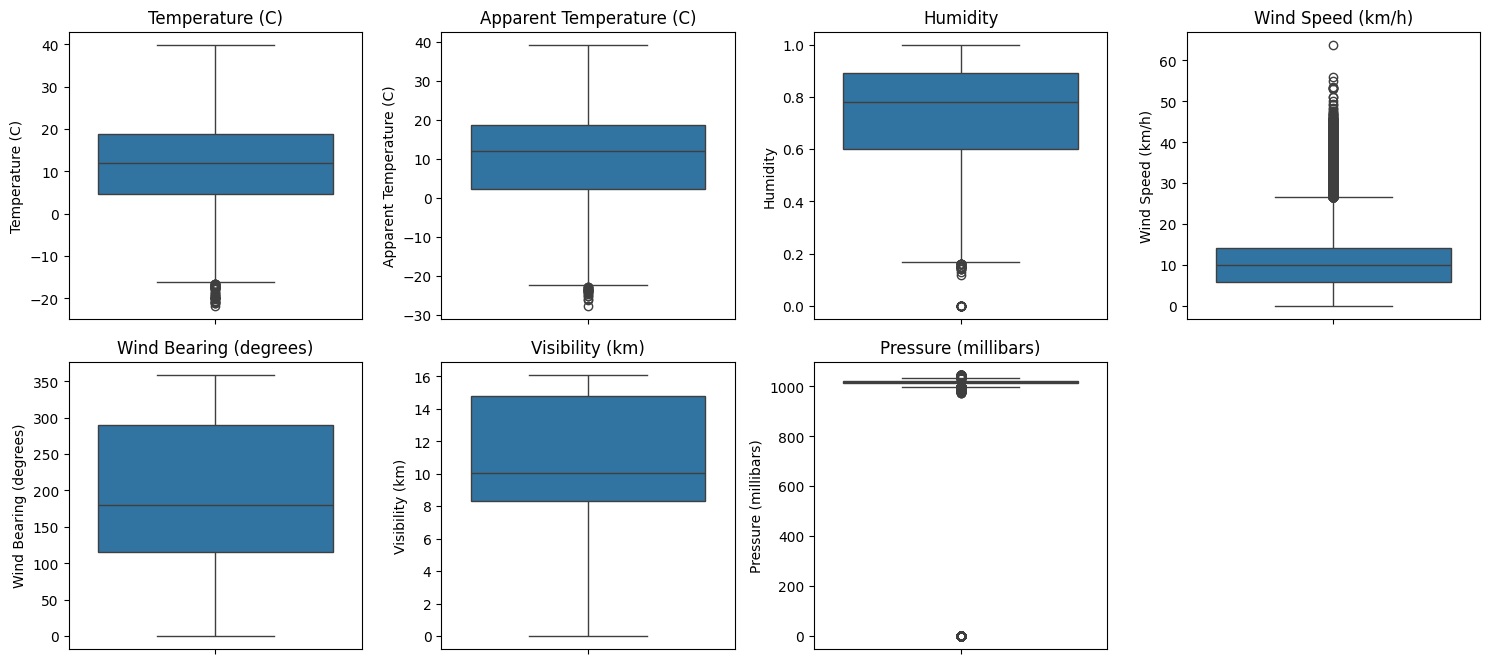

In [11]:
# Boxplot to show Outliers in Numerical Features
plt.figure(figsize=(15, 10))

# Create boxplots for all numerical columns
df_numeric = df.select_dtypes(include=['float64', 'int64'])

for i, col in enumerate(df_numeric.columns, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()


In [12]:
# Removing Outliers
numerical_cols = df.select_dtypes(include=[np.number]).columns
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


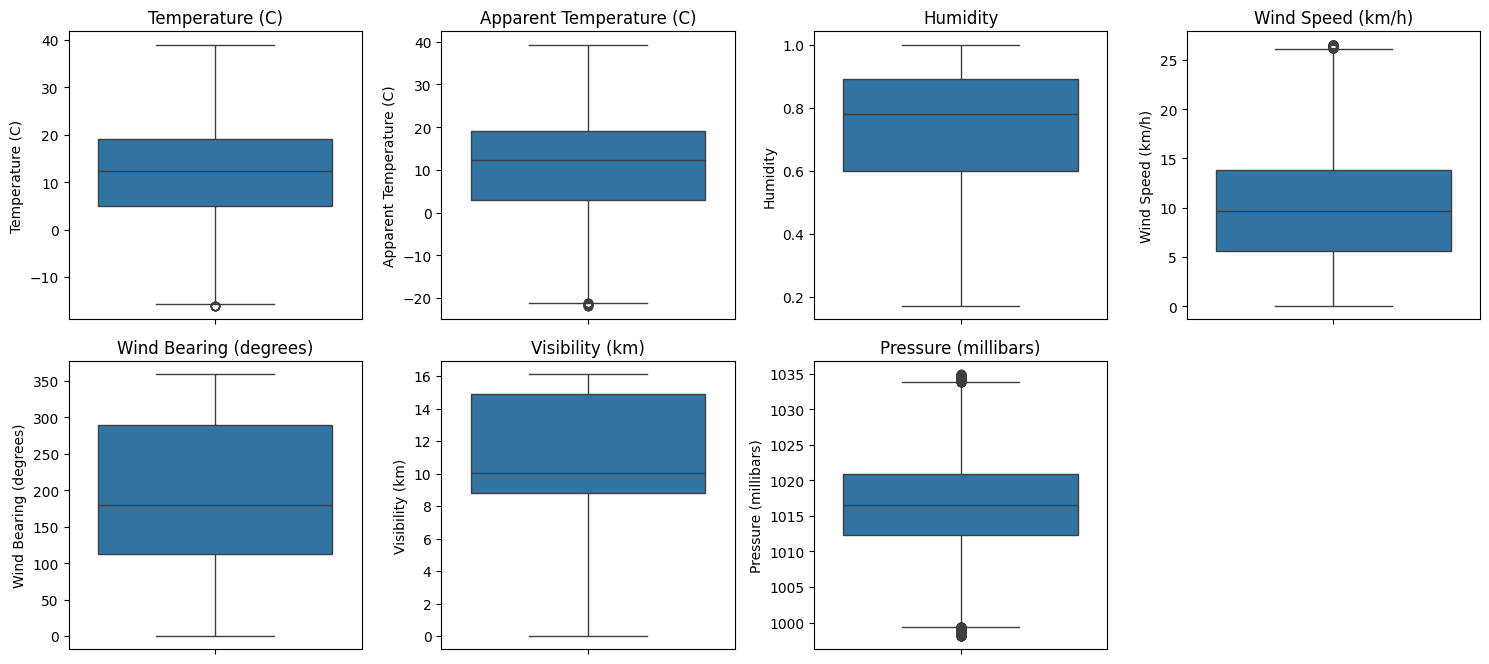

In [13]:
# showing boxplot after outlier removal from numerical features
plt.figure(figsize=(15, 10))

df_numeric = df.select_dtypes(include=['float64', 'int64'])

for i, col in enumerate(df_numeric.columns, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

In [14]:
print(df.shape)

(89265, 10)


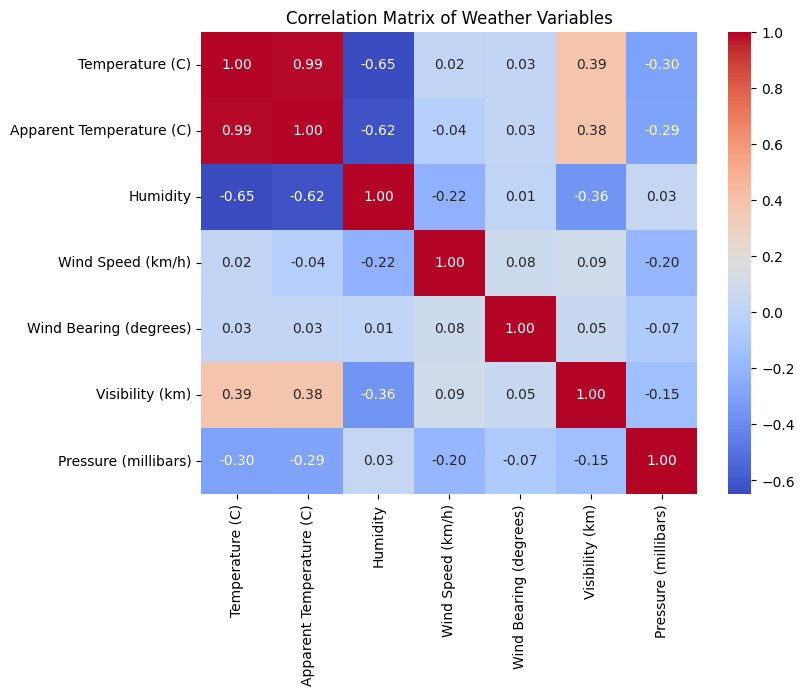

In [15]:
#Correlation Matrix for visualizing relation between numerical features

numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Weather Variables')
plt.show()

In [16]:
"""
Removing Apparent Temperature (C) Column (perceived temperature felt by humans) as it is highly correlated with the tempreature column
meaning it provides redundant information and to avoid multicollinearity.
"""
df.drop(columns=['Apparent Temperature (C)'], inplace=True)

In [17]:
display(df.head())

,Formatted Date,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,0.89,14.1197,251.0,15.8263,1015.13
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,0.86,14.2646,259.0,15.8263,1015.63
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,0.89,3.9284,204.0,14.9569,1015.94
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,0.83,14.1036,269.0,15.8263,1016.41
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,0.83,11.0446,259.0,15.8263,1016.51


In [18]:
# Creating Time Features
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)
df.set_index('Formatted Date', inplace=True)
df['Hour'] = df.index.hour
df['Day of Week'] = df.index.dayofweek
df['Month'] = df.index.month
df['Rolling Temp'] = df['Temperature (C)'].rolling(window=3, min_periods=1).mean()

In [19]:
display(df.head())

,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Hour,Day of Week,Month,Rolling Temp
Formatted Date,,,,,,,,,,,,
2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,0.89,14.1197,251.0,15.8263,1015.13,22,4,3,9.472222
2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,0.86,14.2646,259.0,15.8263,1015.63,23,4,3,9.413889
2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,0.89,3.9284,204.0,14.9569,1015.94,0,5,4,9.401852
2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,0.83,14.1036,269.0,15.8263,1016.41,1,5,4,9.007407
2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,0.83,11.0446,259.0,15.8263,1016.51,2,5,4,8.807407


In [20]:
# Encoding Categorical Features
categorical_cols = ['Summary', 'Precip Type']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

df = df.reset_index()

df = df.drop(columns=categorical_cols)
df = pd.concat([df, encoded_df], axis=1)



In [21]:
display(df.head())

,Formatted Date,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Hour,Day of Week,Month,...,Summary_Foggy,Summary_Humid and Mostly Cloudy,Summary_Humid and Overcast,Summary_Humid and Partly Cloudy,Summary_Light Rain,Summary_Mostly Cloudy,Summary_Overcast,Summary_Partly Cloudy,Summary_Rain,Precip Type_snow
0,2006-03-31 22:00:00+00:00,9.472222,0.89,14.1197,251.0,15.8263,1015.13,22,4,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2006-03-31 23:00:00+00:00,9.355556,0.86,14.2646,259.0,15.8263,1015.63,23,4,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2006-04-01 00:00:00+00:00,9.377778,0.89,3.9284,204.0,14.9569,1015.94,0,5,4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2006-04-01 01:00:00+00:00,8.288889,0.83,14.1036,269.0,15.8263,1016.41,1,5,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2006-04-01 02:00:00+00:00,8.755556,0.83,11.0446,259.0,15.8263,1016.51,2,5,4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [22]:
df.set_index('Formatted Date', inplace=True)
print(df.shape)
print(df.info())

(89265, 24)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 89265 entries, 2006-03-31 22:00:00+00:00 to 2016-09-09 21:00:00+00:00
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Temperature (C)                  89265 non-null  float64
 1   Humidity                         89265 non-null  float64
 2   Wind Speed (km/h)                89265 non-null  float64
 3   Wind Bearing (degrees)           89265 non-null  float64
 4   Visibility (km)                  89265 non-null  float64
 5   Pressure (millibars)             89265 non-null  float64
 6   Hour                             89265 non-null  int32  
 7   Day of Week                      89265 non-null  int32  
 8   Month                            89265 non-null  int32  
 9   Rolling Temp                     89265 non-null  float64
 10  Summary_Drizzle                  89265 non-null  float64
 11  Summary_Dry          

In [23]:
# Normalizing Numerical Features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
time_features = ['Hour', 'Day of Week', 'Month']

features_to_scale = [col for col in numerical_features if col not in time_features]

scaler = MinMaxScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])


In [24]:
display(df.head())

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Hour,Day of Week,Month,Rolling Temp,...,Summary_Foggy,Summary_Humid and Mostly Cloudy,Summary_Humid and Overcast,Summary_Humid and Partly Cloudy,Summary_Light Rain,Summary_Mostly Cloudy,Summary_Overcast,Summary_Partly Cloudy,Summary_Rain,Precip Type_snow
Formatted Date,,,,,,,,,,,,,,,,,,,,,
2006-03-31 22:00:00+00:00,0.464354,0.867470,0.531193,0.699164,0.983,0.462857,22,4,3,0.462158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2006-03-31 23:00:00+00:00,0.462237,0.831325,0.536644,0.721448,0.983,0.476463,23,4,3,0.461088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2006-04-01 00:00:00+00:00,0.462640,0.867470,0.147789,0.568245,0.929,0.484898,0,5,4,0.460867,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2006-04-01 01:00:00+00:00,0.442876,0.795181,0.530588,0.749304,0.983,0.497687,1,5,4,0.453628,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2006-04-01 02:00:00+00:00,0.451346,0.795181,0.415506,0.721448,0.983,0.500408,2,5,4,0.449958,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [25]:
#  Using Sine and Cosine to Encode Time Cycles and Converting  time features into cyclical representations to help Model understand periodic patterns.
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

df['Day_sin'] = np.sin(2 * np.pi * df['Day of Week'] / 7)
df['Day_cos'] = np.cos(2 * np.pi * df['Day of Week'] / 7)

df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)


df.drop(columns=['Hour', 'Day of Week', 'Month'], inplace=True)



In [26]:
display(df.head())

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Rolling Temp,Summary_Drizzle,Summary_Dry,Summary_Dry and Mostly Cloudy,...,Summary_Overcast,Summary_Partly Cloudy,Summary_Rain,Precip Type_snow,Hour_sin,Hour_cos,Day_sin,Day_cos,Month_sin,Month_cos
Formatted Date,,,,,,,,,,,,,,,,,,,,,
2006-03-31 22:00:00+00:00,0.464354,0.867470,0.531193,0.699164,0.983,0.462857,0.462158,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,-0.500000,0.866025,-0.433884,-0.900969,1.000000,6.123234e-17
2006-03-31 23:00:00+00:00,0.462237,0.831325,0.536644,0.721448,0.983,0.476463,0.461088,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,-0.258819,0.965926,-0.433884,-0.900969,1.000000,6.123234e-17
2006-04-01 00:00:00+00:00,0.462640,0.867470,0.147789,0.568245,0.929,0.484898,0.460867,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,1.000000,-0.974928,-0.222521,0.866025,-5.000000e-01
2006-04-01 01:00:00+00:00,0.442876,0.795181,0.530588,0.749304,0.983,0.497687,0.453628,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.258819,0.965926,-0.974928,-0.222521,0.866025,-5.000000e-01
2006-04-01 02:00:00+00:00,0.451346,0.795181,0.415506,0.721448,0.983,0.500408,0.449958,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.500000,0.866025,-0.974928,-0.222521,0.866025,-5.000000e-01


# Preparing the Data and splitting it For Both Models(LSTM,GRU)

In [27]:
# Split into train and remaining (val + test)
train_data, remaining_data = train_test_split(df, test_size=0.3, shuffle=False)

# Split remaining into validation and test
val_data, test_data = train_test_split(remaining_data, test_size=0.5, shuffle=False)

train_data_np = train_data.to_numpy()
val_data_np = val_data.to_numpy()
test_data_np = test_data.to_numpy()


In [28]:
# Creating sequences  to helps the model recognize trends, seasonality, and recurring patterns.

def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length, 0])
    return np.array(sequences), np.array(targets)

seq_length = 24
X_train, y_train = create_sequences(train_data_np, seq_length)
X_val, y_val = create_sequences(val_data_np, seq_length)
X_test, y_test = create_sequences(test_data_np, seq_length)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Defining the models

In [29]:
# Defining an LSTM-based neural network for time series forecasting.
class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ImprovedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=0.3, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        # Get the last hidden state
        last_hidden_state = lstm_out[:, -1, :]

        # Apply Batch Normalization
        last_hidden_state = self.batch_norm(last_hidden_state)

        out = self.fc(self.relu(last_hidden_state))
        return out

In [30]:
# Defining an GRU-based neural network for time series forecasting.
class ImprovedGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ImprovedGRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True,
                          dropout=0.3, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)

    def forward(self, x):
        gru_out, _ = self.gru(x)

        # Get the last hidden state
        last_hidden_state = gru_out[:, -1, :]

        # Apply Batch Normalization
        last_hidden_state = self.batch_norm(last_hidden_state)

        out = self.fc(self.relu(last_hidden_state))
        return out

# Functions for Training and Evaluating both Models.

In [31]:
def train_model(model, train_loader, val_loader, epochs=30, learning_rate=0.0005):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # Validation phase
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                epoch_val_loss += loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    return train_loss_history, val_loss_history

In [32]:
def evaluate_model(model, X_test, y_test, xlim=None):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).cpu().numpy().flatten()
        y_test = y_test.cpu().numpy().flatten()


    min_len = min(len(y_test), len(predictions))
    y_test, predictions = y_test[:min_len], predictions[:min_len]


    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)


    print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R-squared: {r2:.4f}')


    fig, ax = plt.subplots(2, 1, figsize=(14, 10), dpi=100)

    # --- First Plot: Actual vs Predicted ---
    ax[0].plot(y_test, label='Actual', linestyle='-', linewidth=2, color='blue', alpha=0.8)
    ax[0].plot(predictions, label='Predicted', linestyle='--', linewidth=2, color='orange', alpha=0.8)

    ax[0].set_title("Actual vs Predicted", fontsize=14, fontweight='bold')
    ax[0].set_xlabel("Time", fontsize=12)
    ax[0].set_ylabel("Value", fontsize=12)
    ax[0].legend(loc='upper right', fontsize=10, frameon=True)
    ax[0].grid(True, linestyle='--', alpha=0.5)

    # Apply x-axis limit if provided
    if xlim:
        ax[0].set_xlim(xlim)

    # --- Second Plot: Residuals ---
    residuals = y_test - predictions
    ax[1].scatter(np.arange(len(residuals)), residuals, color='red', alpha=0.5, label='Residuals', s=10)
    ax[1].axhline(y=0, color='black', linestyle='--', linewidth=1)

    ax[1].set_title("Residuals (Actual - Predicted)", fontsize=14, fontweight='bold')
    ax[1].set_xlabel("Time", fontsize=12)
    ax[1].set_ylabel("Residual", fontsize=12)
    ax[1].legend(loc='upper right', fontsize=10, frameon=True)
    ax[1].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()



# Models Initialization and Training

In [33]:
# LSTM Model initialization and training

input_size = X_train.shape[2]
hidden_size = 128
num_layers = 6
output_size = 1

lstm_model = ImprovedLSTMModel(input_size, hidden_size, num_layers, output_size)
lstm_train_loss, lstm_val_loss = train_model(lstm_model, train_loader, val_loader)



Epoch 1/30, Train Loss: 0.008128, Val Loss: 0.051971
Epoch 2/30, Train Loss: 0.002563, Val Loss: 0.024079
Epoch 3/30, Train Loss: 0.002395, Val Loss: 0.011913
Epoch 4/30, Train Loss: 0.001875, Val Loss: 0.008149
Epoch 5/30, Train Loss: 0.001393, Val Loss: 0.001907
Epoch 6/30, Train Loss: 0.001222, Val Loss: 0.001715
Epoch 7/30, Train Loss: 0.001089, Val Loss: 0.001222
Epoch 8/30, Train Loss: 0.001026, Val Loss: 0.001424
Epoch 9/30, Train Loss: 0.000924, Val Loss: 0.000888
Epoch 10/30, Train Loss: 0.000926, Val Loss: 0.000735
Epoch 11/30, Train Loss: 0.000857, Val Loss: 0.000716
Epoch 12/30, Train Loss: 0.001116, Val Loss: 0.000885
Epoch 13/30, Train Loss: 0.000807, Val Loss: 0.000746
Epoch 14/30, Train Loss: 0.000829, Val Loss: 0.000864
Epoch 15/30, Train Loss: 0.001185, Val Loss: 0.001584
Epoch 16/30, Train Loss: 0.000881, Val Loss: 0.001591
Epoch 17/30, Train Loss: 0.000800, Val Loss: 0.000893
Epoch 18/30, Train Loss: 0.000754, Val Loss: 0.000708
Epoch 19/30, Train Loss: 0.000736, Va

In [34]:
# GRU Model initialization and training
input_size = X_train.shape[2]
hidden_size = 128
num_layers = 6
output_size = 1

gru_model = ImprovedGRUModel(input_size, hidden_size, num_layers, output_size)
gru_train_loss, gru_val_loss = train_model(gru_model, train_loader, val_loader)

Epoch 1/30, Train Loss: 0.008338, Val Loss: 0.001781
Epoch 2/30, Train Loss: 0.002718, Val Loss: 0.003083
Epoch 3/30, Train Loss: 0.002066, Val Loss: 0.001655
Epoch 4/30, Train Loss: 0.001874, Val Loss: 0.000785
Epoch 5/30, Train Loss: 0.001684, Val Loss: 0.000806
Epoch 6/30, Train Loss: 0.001709, Val Loss: 0.001819
Epoch 7/30, Train Loss: 0.003162, Val Loss: 0.001165
Epoch 8/30, Train Loss: 0.001492, Val Loss: 0.001589
Epoch 9/30, Train Loss: 0.001672, Val Loss: 0.000720
Epoch 10/30, Train Loss: 0.001124, Val Loss: 0.000592
Epoch 11/30, Train Loss: 0.000994, Val Loss: 0.000541
Epoch 12/30, Train Loss: 0.000923, Val Loss: 0.000803
Epoch 13/30, Train Loss: 0.001489, Val Loss: 0.000715
Epoch 14/30, Train Loss: 0.001116, Val Loss: 0.000612
Epoch 15/30, Train Loss: 0.000930, Val Loss: 0.000635
Epoch 16/30, Train Loss: 0.000869, Val Loss: 0.000565
Epoch 17/30, Train Loss: 0.000843, Val Loss: 0.000571
Epoch 18/30, Train Loss: 0.000796, Val Loss: 0.000661
Epoch 19/30, Train Loss: 0.000802, Va

# Evaluating Both Models Performance

MAE: 0.0153, MSE: 0.0005, R-squared: 0.9801


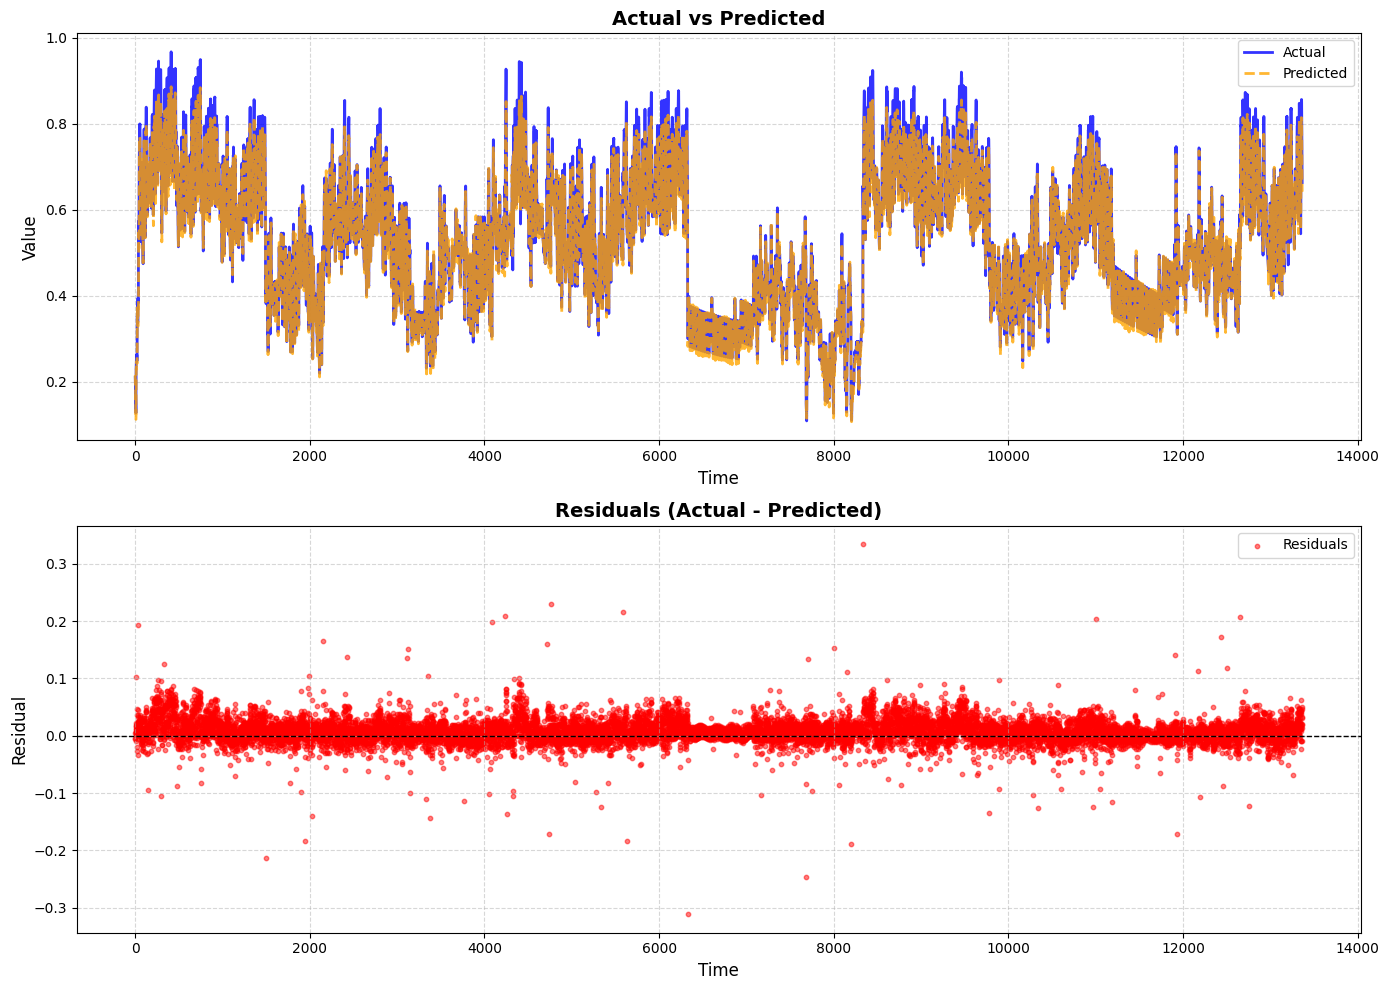

In [35]:
#Evaluating the LSTM Model Performance
evaluate_model(lstm_model, X_test_tensor, y_test_tensor)


MAE: 0.0133, MSE: 0.0004, R-squared: 0.9845


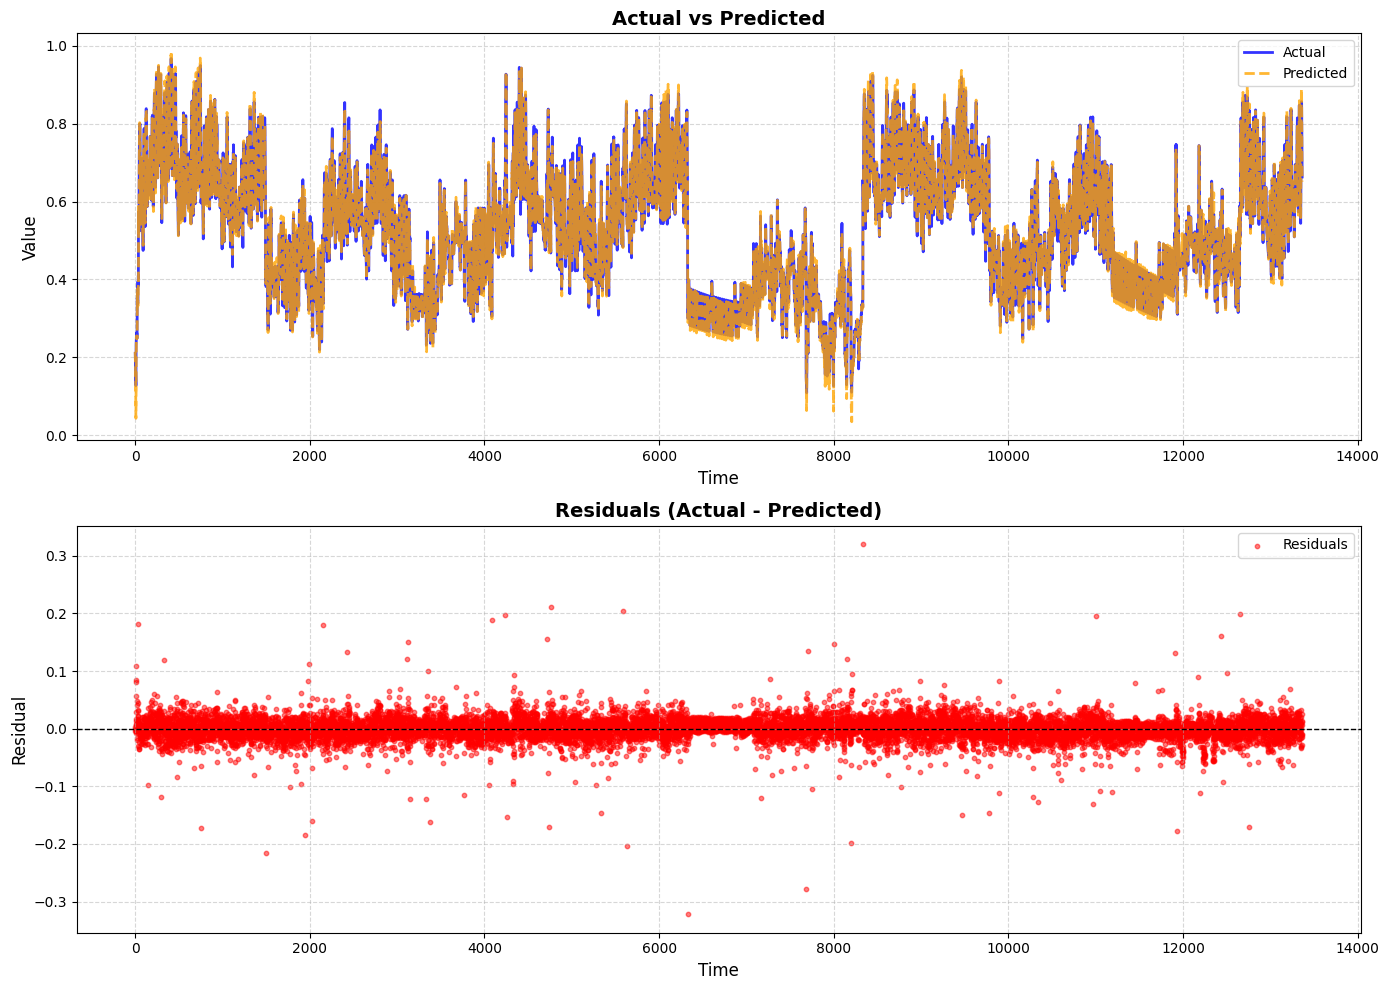

In [36]:
#Evaluating the GRU Model Performance
evaluate_model(gru_model, X_test_tensor, y_test_tensor)

MAE: 0.0153, MSE: 0.0005, R-squared: 0.9801


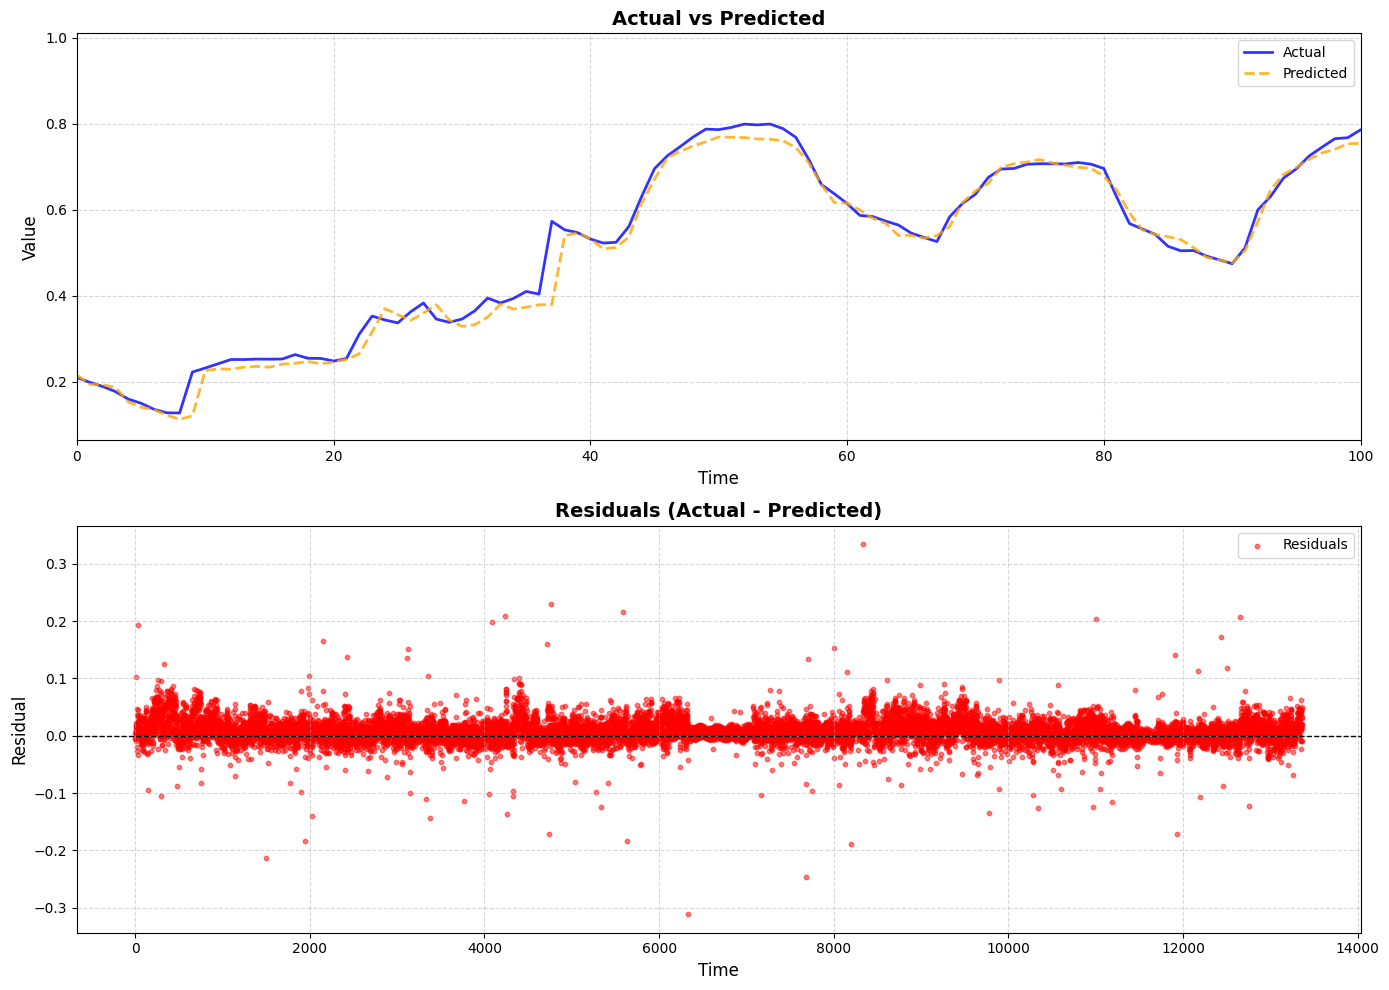

In [37]:
evaluate_model(lstm_model, X_test_tensor, y_test_tensor, xlim=(0, 100))

MAE: 0.0133, MSE: 0.0004, R-squared: 0.9845


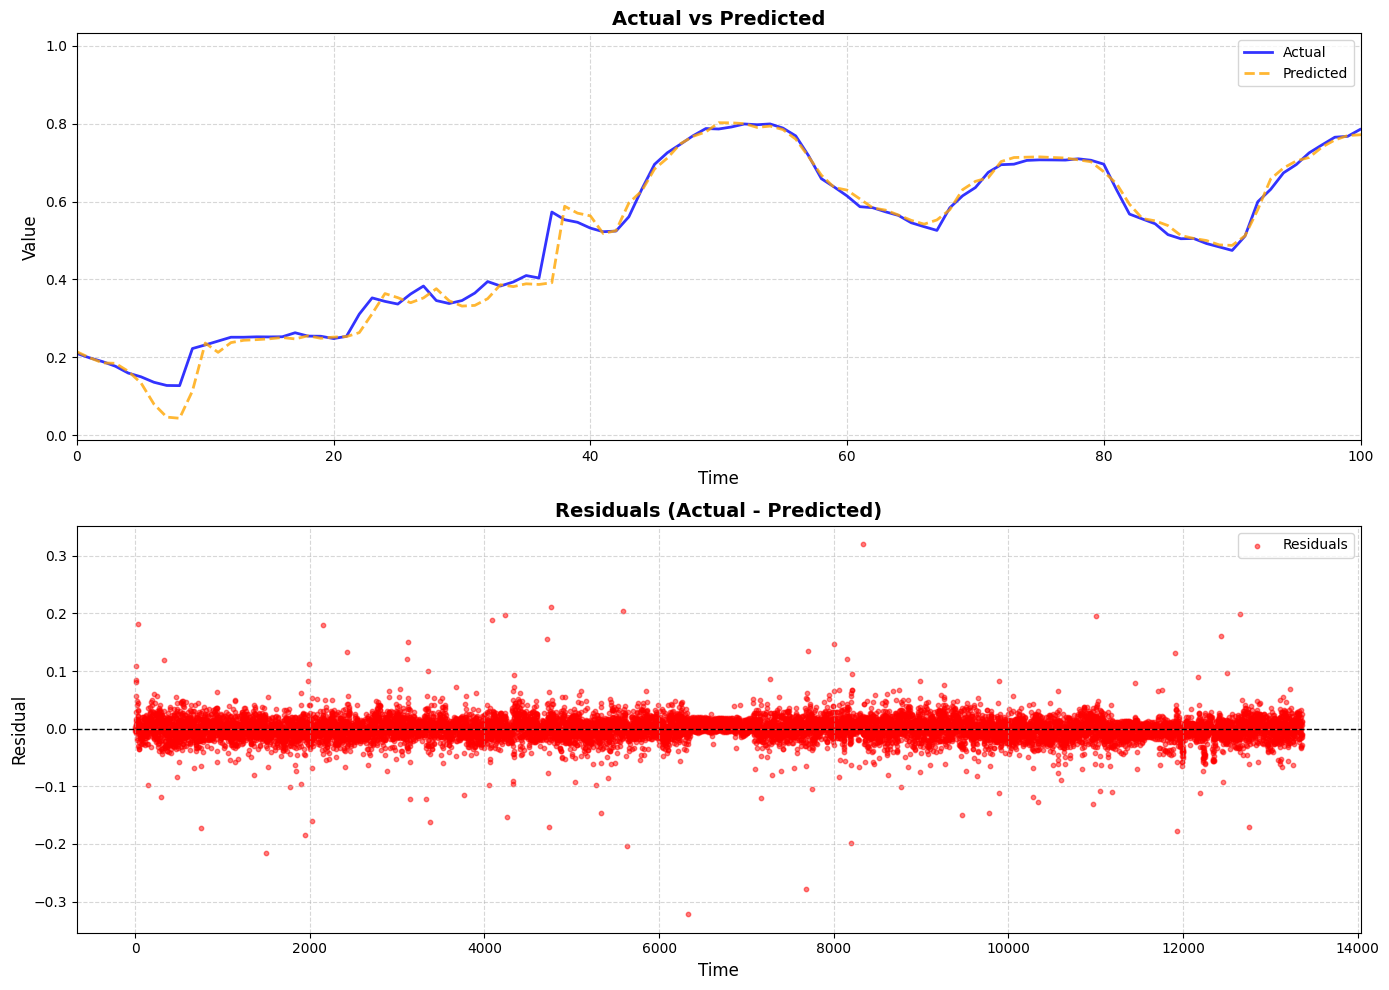

In [39]:
evaluate_model(gru_model, X_test_tensor, y_test_tensor, xlim=(0, 100))

* Both models showed good performance however, the GRU model showed a slight edge, achieving better accuracy and generalization. This suggests that GRU Model may be more effective in capturing temporal dependencies within the dataset.  

